# Let’s Help Santa!

Go to “Uber Movement” website and download data of Monthly Aggregate (all days), 2017 Quarter 4, for San Francisco area1. The dataset contains pairwise traveling time statistics between most pairs of points in San Francisco area. Points on the map are represented by unique IDs. To understand the correspondence between map IDs and areas, download Geo Boundaries file from the same website2. This file contains latitudes and longitudes of the corners of the polygons circumscribing each area. In addition, it contains one street address inside each area, referred to as DISPLAY NAME. To be specific, if an area is represented by a polygon with 5 corners, then you have a 5 × 2 matrix of the latitudes and longitudes, each row of which represents latitude and longitude of one corner.

## Question 6:
Report the number of nodes and edges in G.

In [224]:
import numpy as np
import pandas as pd
import json as js
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
%matplotlib inline

data = pd.read_csv('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv', header=0, sep=',')
json_data = pd.read_json("san_francisco_censustracts.json")

In [225]:
# Get node attribute and add node to graph
node_dic = {}
G = nx.Graph()

for node_info in json_data['features']:
    node_id = int(node_info['properties']['MOVEMENT_ID'])
    if node_id in node_dic:
        print('WTf')
    else:
        dis_name = node_info['properties']['DISPLAY_NAME']
        location = np.mean(np.array(node_info['geometry']['coordinates'][0][0]), axis=0)
        node_dic[node_id] = {'DISPLAY_NAME':dis_name, 'Location':location}
        G.add_node(node_id, name=dis_name, Location=location)

In [226]:
data_row = data.shape[0]
data_col = data.shape[1]
edge_dic = {}

# Get edges and avg of multi-edges
for idx in range(data_row):
    if int(data['month'][idx]) != 12:
        continue
    edge_w = float(data['mean_travel_time'][idx])
    sourceid = int(data['sourceid'][idx])
    dstid = int(data['dstid'][idx])
    if (sourceid, dstid) in edge_dic:
        edge_dic[(sourceid, dstid)][0] += edge_w
        edge_dic[(sourceid, dstid)][1] += 1
    elif (dstid, sourceid) in edge_dic:
        edge_dic[(dstid, sourceid)][0] += edge_w
        edge_dic[(dstid, sourceid)][1] += 1
    else:
        edge_dic[(sourceid, dstid)] = [edge_w, 1]

In [227]:
# add edges to the graph
for key, item in edge_dic.items():
    w = item[0]/item[1]
    G.add_edge(key[0], key[1], weight=w)
    
Gcc = max(nx.connected_component_subgraphs(G), key=len)

In [228]:
print("Number of nodes are:", nx.number_of_nodes(Gcc))
print("Number of edges are:", nx.number_of_edges(Gcc))

Number of nodes are: 1898
Number of edges are: 321703


## Question 7:
Build a minimum spanning tree (MST) of graph G. Report the street addresses of the two endpoints of a few edges. Are the results intuitive?

In [229]:
MST = nx.minimum_spanning_tree(Gcc)

In [230]:
for point in sorted(nx.edges(MST)):
    print(node_dic[point[0]]["DISPLAY_NAME"], "----", node_dic[point[1]]["DISPLAY_NAME"])

400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 1500 Oxford Street, Palm Park, Redwood City
400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 100 Fifth Avenue, South Fair Oaks, Redwood City
18300 Sutter Boulevard, Morgan Hill ---- 17300 Lotus Way, Morgan Hill
18300 Sutter Boulevard, Morgan Hill ---- 1900 Alpet Drive, Morgan Hill
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 8900 Cal Center Drive, Sacramento
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 9500 River Rose Way, Premier Garden, Sacramento
100 Carlsbad Circle, Vacaville ---- Interstate 505, Vacaville
100 Carlsbad Circle, Vacaville ---- 500 Morningstar Way, Vacaville
Unnamed Road, Vacaville ---- 400 Bowline Drive, Vacaville
Unnamed Road, Vacaville ---- 100 Monte Verde Drive, Vacaville
700 Carlsbad Court, Petaluma ---- 0 Maria Drive, Petaluma
700 Carlsbad Court, Petaluma ---- 200 Ely Road North, Petaluma
700 Carlsbad Court, Petaluma ---- 900 Telford Lane, Petaluma
500 Hyde Street, Tenderloin, San

Old Suisun Knoxville Road, Napa ---- 1400 South Whitehall Lane, Saint Helena
Old Suisun Knoxville Road, Napa ---- 3000 Old Soda Springs Road, Napa
900 Westacre Road, West Sacramento ---- 1200 Halyard Drive, West Sacramento
1400 San Rafael Street, Estudillo Estates - Glen, San Leandro ---- 900 Dowling Boulevard, Broadmoor, San Leandro
1400 San Rafael Street, Estudillo Estates - Glen, San Leandro ---- 2000 Evergreen Avenue, Assumption Parish, San Leandro
Jeep Trail Usgs, Brooks ---- 25400 County Road 29, Winters
3000 Adeline Street, Clawson, Oakland ---- 1100 Park Avenue, Emeryville
2700 Pleasant Street, School, Oakland ---- 2900 Sheffield Avenue, Reservoir Hills, Oakland
2700 Pleasant Street, School, Oakland ---- 3200 Suter Street, Upper Peralta Creek, Oakland
1000 66th Avenue, Coliseum, Oakland ---- 1100 77th Avenue, Fitchburg, Oakland
2000 Francisco Street, North Berkeley, Berkeley ---- 2000 Rose Street, North Berkeley, Berkeley
2500 Parker Street, Elmwood, Berkeley ---- 2400 Channing

## Question 8:
Determine what percentage of triangles in the graph (sets of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate by random sampling of 1000 triangles.

In [231]:
import random

node_scale = max(node_dic.keys())
sample_num = 0
triangle_num = 0
used = set()

while sample_num < 1000:
    sourceid = random.randint(1, node_scale)
    dstid = random.randint(1, node_scale)
    midid = random.randint(1, node_scale)
    if sourceid != midid != dstid and (sourceid, dstid) in edge_dic \
    and (sourceid, midid) in edge_dic and (midid, dstid) in edge_dic \
    and (sourceid, midid, dstid) not in used:
        used.add((sourceid, midid, dstid))
        sample_num += 1
        dij = edge_dic[(sourceid, midid)][0]/edge_dic[(sourceid, midid)][1]
        djk = edge_dic[(midid, dstid)][0]/edge_dic[(midid, dstid)][1]
        dik = edge_dic[(sourceid, dstid)][0]/edge_dic[(sourceid, dstid)][1]
        if dij+djk > dik:
            triangle_num += 1

print(triangle_num/sample_num*100, "% of triangles in the graph satisfy the triangle inequality", sep='')

96.7% of triangles in the graph satisfy the triangle inequality


## Question 9:
Find an upper bound on the empirical performance of the approximate algorithm:
$$\rho = \frac{\text{Approximate TSP Cost}}{\text{Optimal TSP Cost}}$$

In [232]:
# Create multi-graph
Multi_G = nx.MultiDiGraph()
Multi_G.add_nodes_from(MST)
path = []

for edge in MST.edges:
    w = MST.edges[edge]['weight']
    Multi_G.add_edge(edge[0], edge[1], weight=w)
    Multi_G.add_edge(edge[1], edge[0], weight=w)
    
# Find Euler-circle
Euler_circle = nx.eulerian_circuit(Multi_G)

# Calculate the length of the tour from Euler-circle
# (There are multiple Euler-circles, here we only choose the first circle)
travel_length = 0
idx = 0

for edge in Euler_circle:
    if idx == 0:
        start = edge[0]
    if edge[1] == start:
        print(edge[0])
        dst = edge[0]
        path.append(dst)
        print('---------------------------------------')
        break
    travel_length += Multi_G.edges[edge[0], edge[1], 0]['weight']
    path.append(edge[0])
    print(edge[0], "->", end=' ')
    idx += 1
    
print("Approximate TSP cost is:", travel_length)

2 -> 1727 -> 530 -> 1734 -> 2456 -> 531 -> 2378 -> 2607 -> 2240 -> 1852 -> 2240 -> 2607 -> 2378 -> 531 -> 1725 -> 1726 -> 2251 -> 1736 -> 1737 -> 1363 -> 1737 -> 1736 -> 2251 -> 1726 -> 1725 -> 531 -> 2456 -> 1734 -> 530 -> 394 -> 1721 -> 1724 -> 2513 -> 2229 -> 2513 -> 232 -> 2155 -> 347 -> 1851 -> 347 -> 1359 -> 881 -> 562 -> 125 -> 1850 -> 1849 -> 1848 -> 1849 -> 1850 -> 125 -> 562 -> 86 -> 2305 -> 741 -> 345 -> 1833 -> 920 -> 1832 -> 1838 -> 1337 -> 1357 -> 1825 -> 2222 -> 2223 -> 1853 -> 744 -> 2490 -> 744 -> 1869 -> 1361 -> 1358 -> 742 -> 1358 -> 1361 -> 1869 -> 744 -> 1853 -> 2223 -> 2222 -> 1333 -> 1948 -> 1333 -> 829 -> 2656 -> 1949 -> 1937 -> 557 -> 1936 -> 2221 -> 1936 -> 725 -> 1947 -> 725 -> 1936 -> 557 -> 1311 -> 1329 -> 824 -> 1935 -> 1933 -> 1935 -> 1331 -> 1934 -> 2376 -> 1934 -> 2232 -> 1934 -> 1331 -> 1935 -> 1222 -> 2173 -> 724 -> 1330 -> 390 -> 1871 -> 1381 -> 831 -> 745 -> 831 -> 1381 -> 170 -> 1381 -> 1871 -> 563 -> 1872 -> 563 -> 1871 -> 390 -> 1330 -> 724 -> 21

-> 2066 -> 2429 -> 2069 -> 761 -> 2067 -> 146 -> 2067 -> 840 -> 295 -> 1183 -> 182 -> 1185 -> 2272 -> 2126 -> 1184 -> 2020 -> 2000 -> 398 -> 2387 -> 1478 -> 2387 -> 296 -> 762 -> 841 -> 762 -> 296 -> 2387 -> 398 -> 2000 -> 1996 -> 372 -> 253 -> 39 -> 571 -> 2023 -> 749 -> 2022 -> 2540 -> 1038 -> 1545 -> 478 -> 1050 -> 1546 -> 1547 -> 627 -> 2612 -> 2487 -> 2612 -> 2201 -> 2612 -> 627 -> 1547 -> 100 -> 2209 -> 479 -> 954 -> 57 -> 102 -> 55 -> 102 -> 1651 -> 1655 -> 1047 -> 417 -> 628 -> 31 -> 1658 -> 109 -> 1054 -> 1659 -> 1054 -> 109 -> 1522 -> 1523 -> 1070 -> 1523 -> 1524 -> 2224 -> 462 -> 596 -> 2401 -> 1515 -> 431 -> 1515 -> 2401 -> 596 -> 97 -> 596 -> 462 -> 1071 -> 1525 -> 887 -> 1525 -> 1514 -> 1072 -> 96 -> 1074 -> 597 -> 1074 -> 96 -> 1072 -> 1514 -> 2620 -> 463 -> 2620 -> 2349 -> 1516 -> 1518 -> 283 -> 1081 -> 283 -> 456 -> 58 -> 456 -> 283 -> 1518 -> 464 -> 1512 -> 2212 -> 194 -> 1030 -> 886 -> 284 -> 886 -> 2213 -> 457 -> 808 -> 1498 -> 808 -> 285 -> 1080 -> 1504 -> 1080 -> 

 -> 876 -> 746 -> 876 -> 187 -> 699 -> 391 -> 975 -> 820 -> 77 -> 820 -> 698 -> 1928 -> 547 -> 1927 -> 2521 -> 436 -> 1925 -> 436 -> 2173 -> 1222 -> 1935 -> 824 -> 1332 -> 2596 -> 1332 -> 824 -> 1329 -> 1311 -> 557 -> 1937 -> 1949 -> 1334 -> 1335 -> 2363 -> 1309 -> 1917 -> 722 -> 2535 -> 722 -> 1918 -> 419 -> 1931 -> 2677 -> 1931 -> 2172 -> 1932 -> 723 -> 1932 -> 2172 -> 1931 -> 419 -> 1310 -> 419 -> 1918 -> 722 -> 1917 -> 1309 -> 930 -> 1914 -> 823 -> 1915 -> 823 -> 1307 -> 556 -> 1307 -> 823 -> 1914 -> 930 -> 380 -> 1919 -> 2145 -> 1929 -> 2146 -> 1930 -> 2146 -> 1929 -> 2145 -> 1919 -> 1233 -> 1308 -> 1233 -> 687 -> 1305 -> 1913 -> 2375 -> 1913 -> 1305 -> 687 -> 544 -> 1903 -> 1232 -> 2171 -> 1232 -> 1903 -> 544 -> 687 -> 1233 -> 1919 -> 695 -> 1920 -> 916 -> 1921 -> 1923 -> 1921 -> 1922 -> 1921 -> 696 -> 546 -> 696 -> 1921 -> 916 -> 1920 -> 695 -> 1237 -> 695 -> 1919 -> 380 -> 930 -> 1309 -> 455 -> 721 -> 1912 -> 720 -> 1911 -> 919 -> 2595 -> 1910 -> 1304 -> 1910 -> 2595 -> 919 -> 

In [233]:
# Get opt_length
opt_length = 0

for edge in MST.edges:
    opt_length += MST.edges[edge]['weight']
    
print("Optimal TSP cost is:", opt_length)

Optimal TSP cost is: 289315.6749999996


In [234]:
print("rho is:", travel_length/opt_length)

rho is: 1.5217849499512983


## Question 10:
Plot the trajectory that Santa has to travel!

Text(0.5, 1.0, 'The trajectory Santa has to travel')

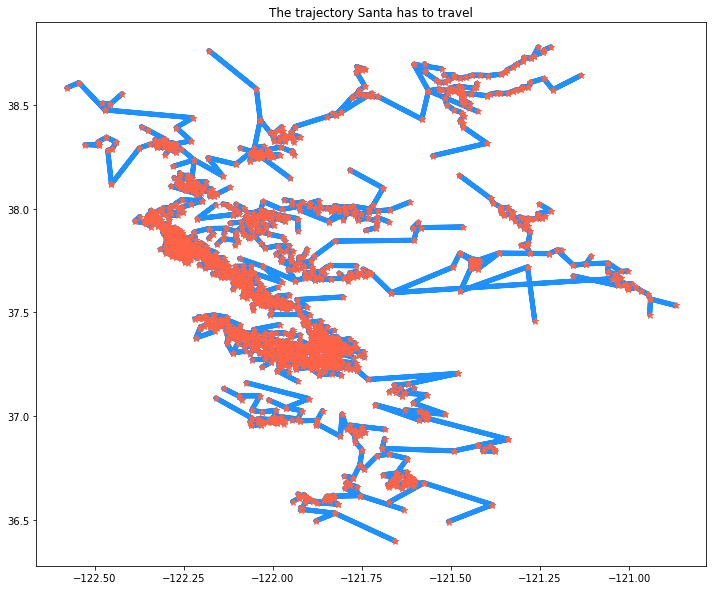

In [245]:
X = []
Y = []

for node in path:
    X.append(node_dic[node]['Location'][0])
    Y.append(node_dic[node]['Location'][1])

# plot the trajectory
plt.figure(figsize=(12, 10))
plt.plot(X, Y, linewidth=5, color='dodgerblue')
plt.plot(X, Y, '*', markersize=7, color='tomato')
plt.title('The trajectory Santa has to travel')

## Question 11:
Plot the road mesh that you obtain and explain the result. Create a graph G∆ whose nodes are different locations and its edges are produced by triangulation.